In [1]:
from environment import TrafficLightEnv
from utils import plot_history

# Environment

In [2]:
ROAD_COUNTS = 4
CHANGE_SIZE = 10
MAX_STATE_VALUE = 200

In [3]:
env = TrafficLightEnv(roads_count=ROAD_COUNTS, change_size=CHANGE_SIZE, max_value=MAX_STATE_VALUE)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('action size', action_size)
print('sample action:', env.action_space.sample())
print('')
print('state size', state_size)
env.render()

action size 15
sample action: 4

state size 16
green light timer [ 14.  48.  36. 139.]
avg waiting times (-) [223. 189. 201.  98.]
vehicles counts (-) [ 11. 187.  17.  77.]
in counts (+) [104.  20. 183. 139.]


# DQN Agent

In [4]:
EPISODES = 1000
EPSILON=1.0
EPSILON_MIN=0.01
EPSILON_DECAY=0.995
LR=5e-4
GAMMA=0.99

In [5]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        # Define the neural network layers
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, output_size)

    def forward(self, x):
        # Define the forward pass through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x

# Define Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.001):
        # Initialize the DQN agent
        self.state_size = state_size  # Dimensionality of the state space
        self.action_size = action_size  # Dimensionality of the action space
        self.memory = []  # Replay memory to store experiences
        self.batch_size = 64  # Batch size for training
        self.gamma = gamma  # Discount factor for future rewards
        self.epsilon = epsilon  # Initial exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for exploration rate
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.lr = lr  # Learning rate for the optimizer
        # Define the DQN model
        self.model = DQN(state_size, action_size)
        # Define the optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def remember(self, state, action, reward, next_state, done):
        # Store the experience tuple (state, action, reward, next_state, done) in memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Choose an action based on epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            # Exploration: Choose a random action
            return random.choice(range(self.action_size))
        else:
            # Exploitation: Choose the action with the highest Q-value
            # Convert the state to a tensor and pass it through the model
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            q_values = self.model(state)
            # Choose the action with the highest Q-value
            return torch.argmax(q_values).item()

    def replay(self):
        # Experience replay: Train the model using experiences stored in memory
        if len(self.memory) < self.batch_size:
            return
        # Sample a mini-batch of experiences from memory
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                # Compute the target Q-value using the target model
                next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
                # if (reward < 0):
                #     target = self.gamma * torch.max(self.model(next_state)).item() - reward
                # else:
                target = self.gamma * torch.max(self.model(next_state)).item() + reward
            # Update the Q-value of the chosen action
            target_f = self.model(torch.tensor(state, dtype=torch.float).unsqueeze(0)).squeeze(0).tolist()
            target_f[action] = target
            # Compute and minimize the Mean Squared Error loss
            self.optimizer.zero_grad()
            state = torch.tensor(np.array(state), dtype=torch.float)
            target_f = torch.tensor(np.array(target_f), dtype=torch.float)
            loss = F.mse_loss(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [6]:
agent = DQNAgent(state_size, action_size, epsilon_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN, lr=LR, gamma=GAMMA)

print('model:', agent.model)

print('')

outputs = agent.model(torch.tensor(env.state, dtype=torch.float).unsqueeze(0))
print('model action output:',[torch.argmax(output).item() for output in outputs])
env.cast_action([torch.argmax(output.clone().detach()) for output in outputs])

model: DQN(
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=64, bias=True)
  (fc8): Linear(in_features=64, out_features=15, bias=True)
)

model action output: [1]


array([1, 1, 1, 1, 1], dtype=int64)

# Deep Q Learning

In [9]:
# Train the agent
total_rewards = []  # List to store rewards for each episode

for episode in range(1, EPISODES + 1):
    state = env.reset()
    done = False
    episode_reward = []

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        episode_reward.append(reward)

    agent.replay()
    total_rewards.append(episode_reward)
    print(f"Episode: {episode}/{EPISODES}, Total Reward: {np.sum(episode_reward)}")

Episode: 1/1000, Total Reward: -17.753125000000004
Episode: 2/1000, Total Reward: -14.643749999999999
Episode: 3/1000, Total Reward: -11.689687499999998
Episode: 4/1000, Total Reward: -23.178750000000004
Episode: 5/1000, Total Reward: -13.088437499999998
Episode: 6/1000, Total Reward: -16.0221875
Episode: 7/1000, Total Reward: -20.329687500000002
Episode: 8/1000, Total Reward: -22.152187500000004
Episode: 9/1000, Total Reward: -11.265
Episode: 10/1000, Total Reward: -22.231249999999996
Episode: 11/1000, Total Reward: -16.5984375
Episode: 12/1000, Total Reward: -22.945
Episode: 13/1000, Total Reward: -20.7459375
Episode: 14/1000, Total Reward: -17.895625
Episode: 15/1000, Total Reward: -15.7284375
Episode: 16/1000, Total Reward: -11.639687499999999
Episode: 17/1000, Total Reward: -22.289062499999996
Episode: 18/1000, Total Reward: -20.204375
Episode: 19/1000, Total Reward: -27.189375
Episode: 20/1000, Total Reward: -13.295312499999998
Episode: 21/1000, Total Reward: -18.159375
Episode: 

In [ ]:
agent.epsilon

0.009888364709658948

# Result

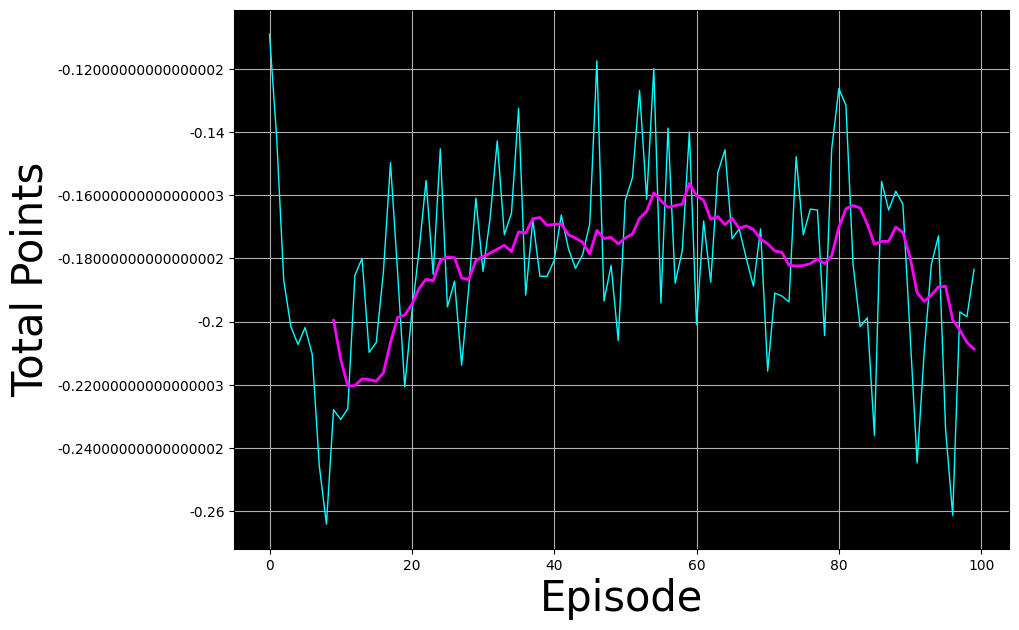

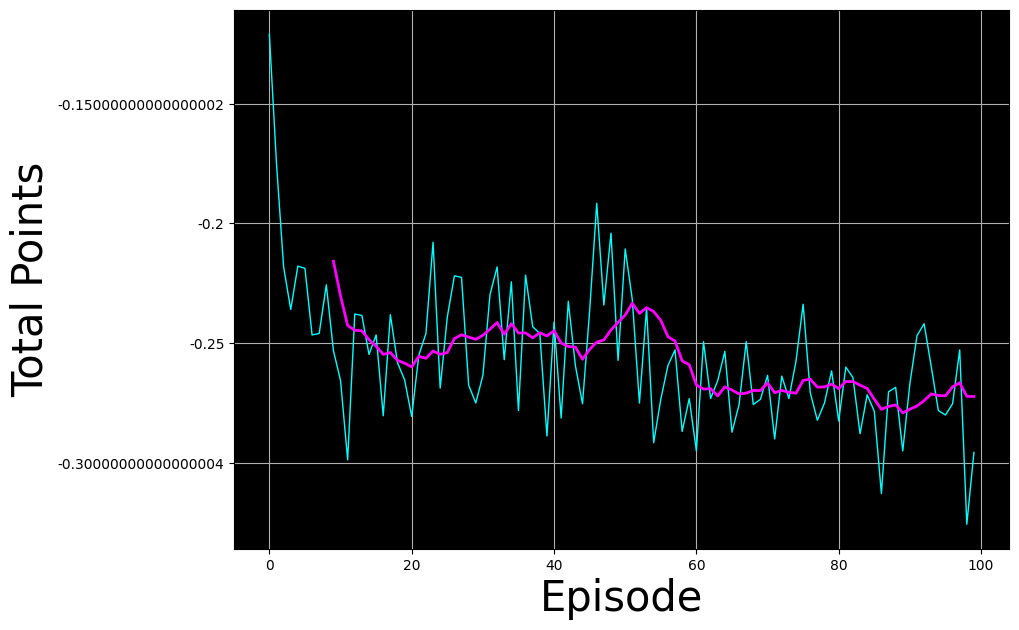

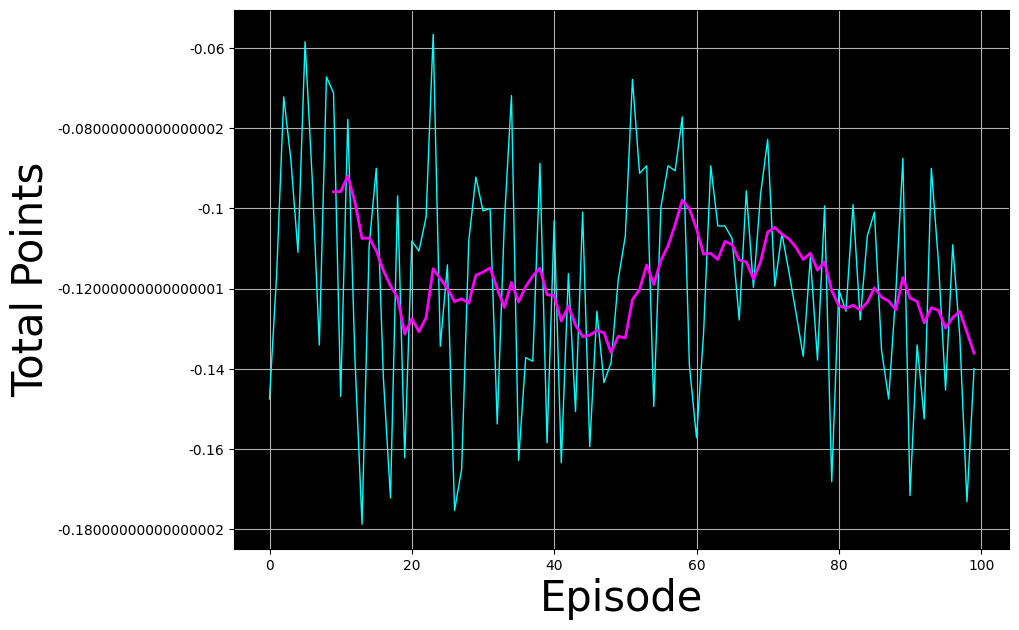

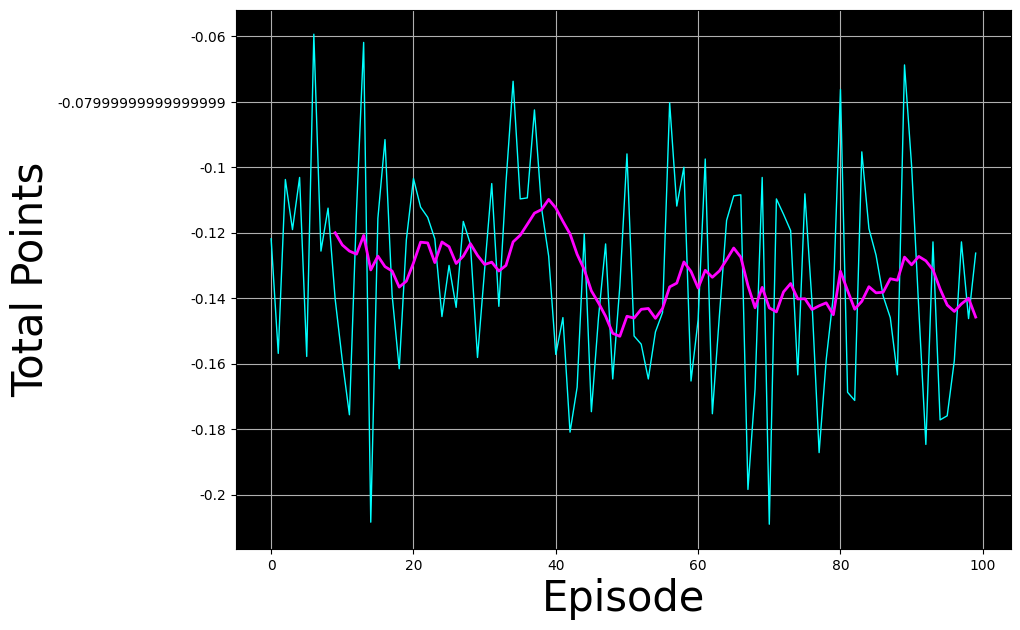

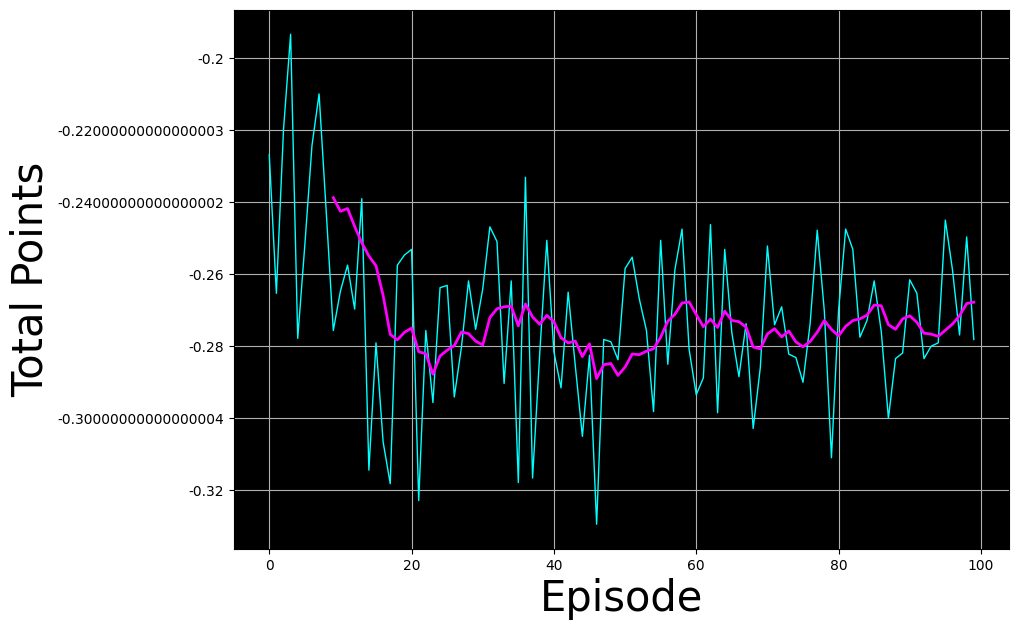

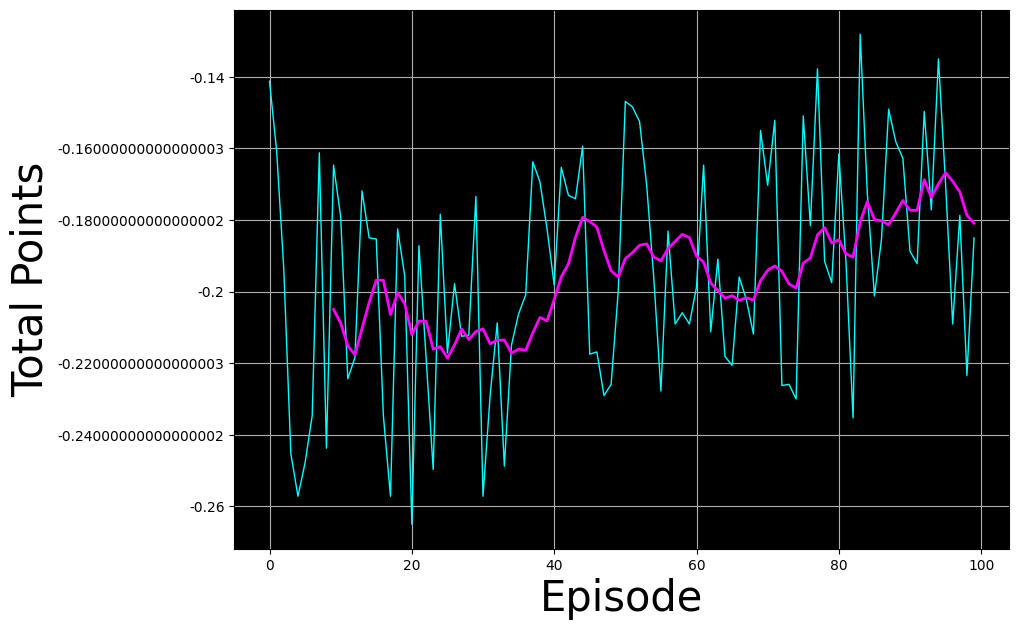

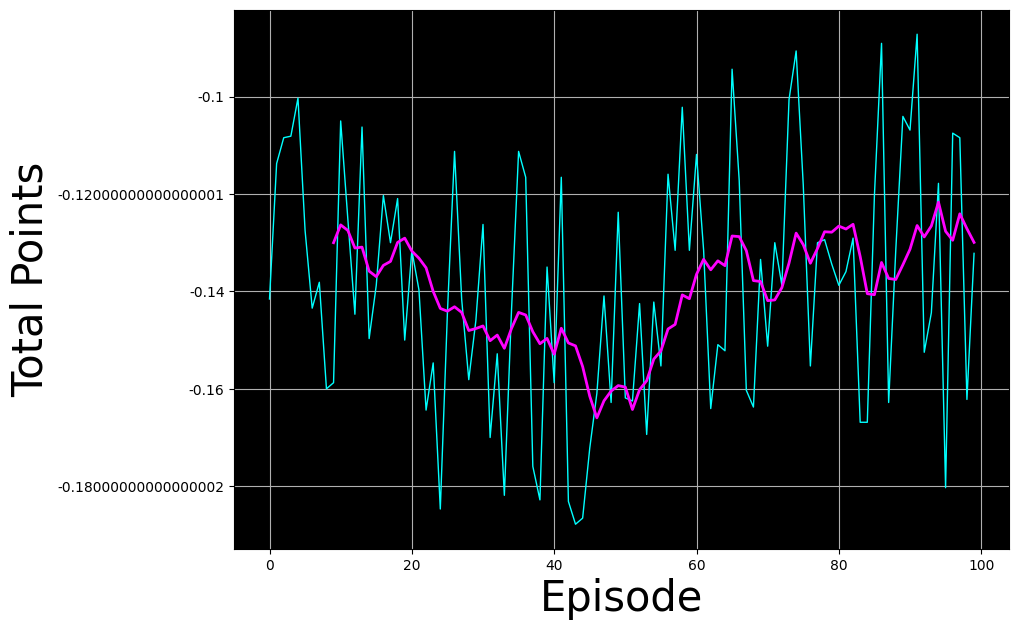

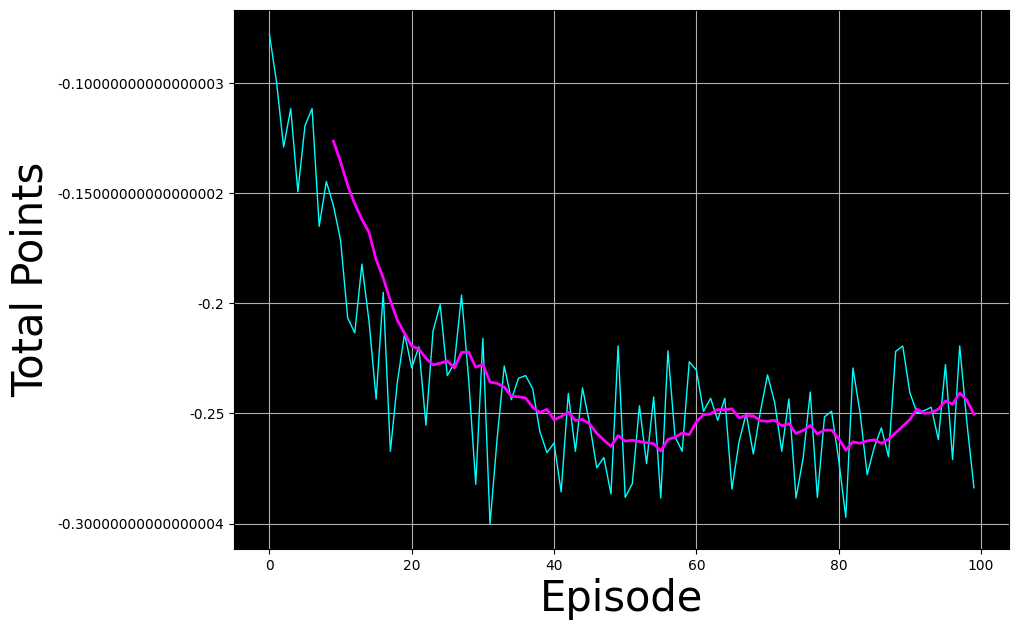

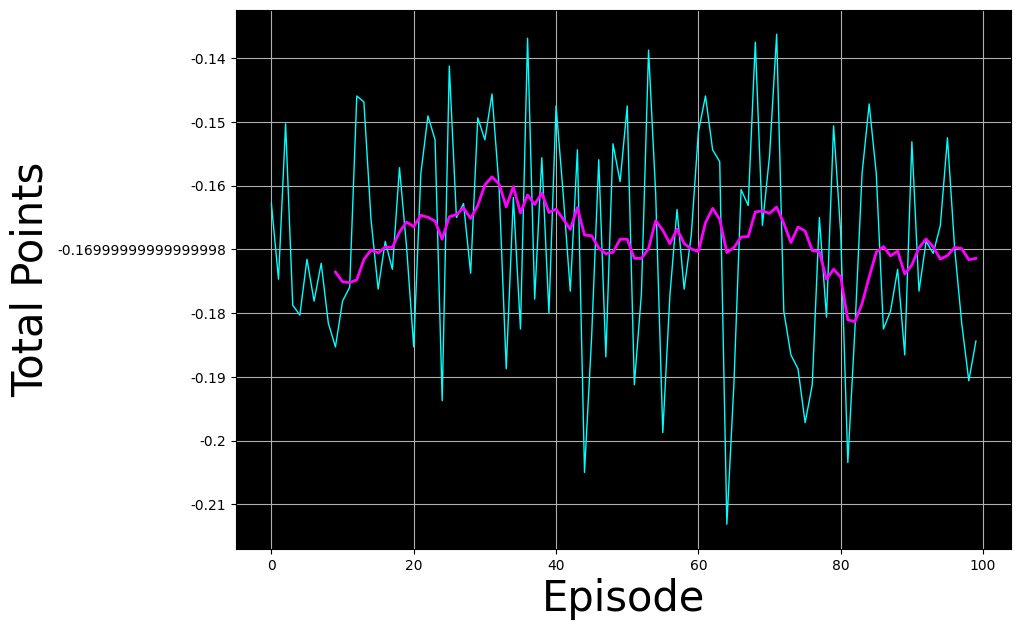

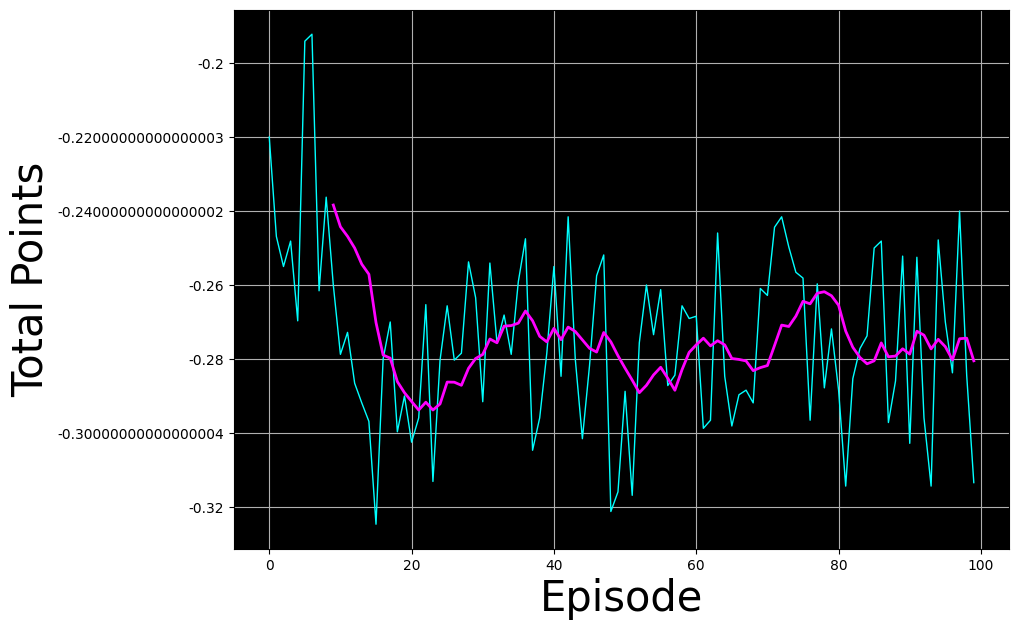

In [ ]:
for episode in range(0, EPISODES, EPISODES//10):
    plot_history(total_rewards[episode])

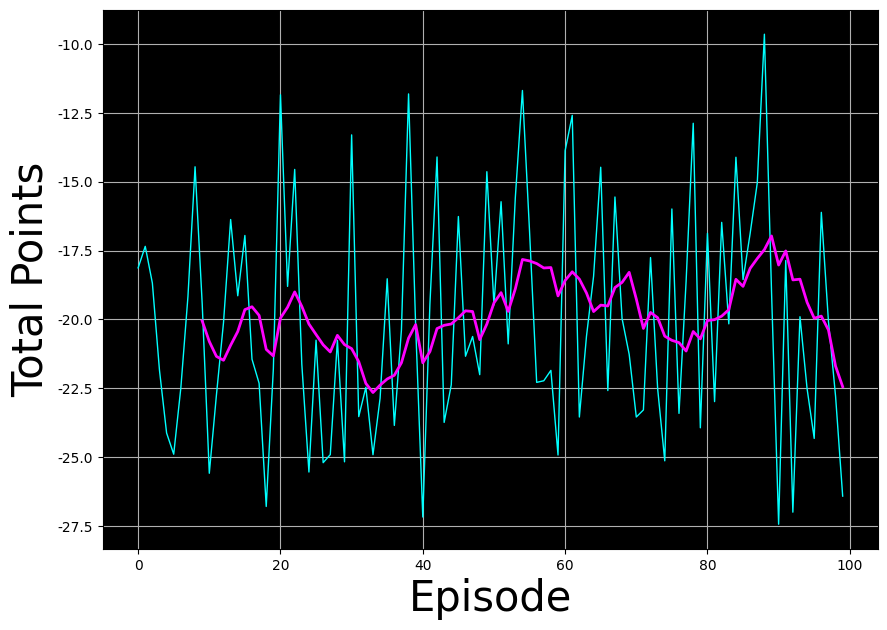

In [ ]:
plot_history(np.sum(total_rewards, axis=1))

## Test

In [ ]:
state = env.reset()
done = False
test_reward = []
while not done:
    env.render()
    state = env.state
    action = agent.act(state)
    print('action taken:', env.cast_action(action))
    print('reward:', reward)
    state, reward, done, _ = env.step(action)
    test_reward.append(reward)
    print('')
env.render()

green light timer [109.  56.  93. 111.]
avg waiting times (-) [260. 313. 276. 258.]
vehicles counts (-) [187.   6. 162. 196.]
in counts (+) [141.  34. 159.  75.]
action taken: [1 1 1 1 1]
reward: -0.243125

green light timer [109.  56.  93. 111.]
avg waiting times (-) [260. 313. 276. 258.]
vehicles counts (-) [136. 126. 199.  89.]
in counts (+) [109.   6.  93. 111.]
action taken: [1 1 1 1 1]
reward: -0.1225

green light timer [109.  56.  93. 111.]
avg waiting times (-) [260. 313. 276. 258.]
vehicles counts (-) [188. 165. 133.  24.]
in counts (+) [109.  56.  93.  89.]
action taken: [1 1 1 1 1]
reward: -0.1046875

green light timer [109.  56.  93. 111.]
avg waiting times (-) [260. 313. 276. 258.]
vehicles counts (-) [103. 116. 181. 109.]
in counts (+) [109.  56.  93.  24.]
action taken: [1 1 1 1 1]
reward: -0.1328125

green light timer [109.  56.  93. 111.]
avg waiting times (-) [260. 313. 276. 258.]
vehicles counts (-) [ 82. 161. 176. 124.]
in counts (+) [103.  56.  93. 109.]
action tak

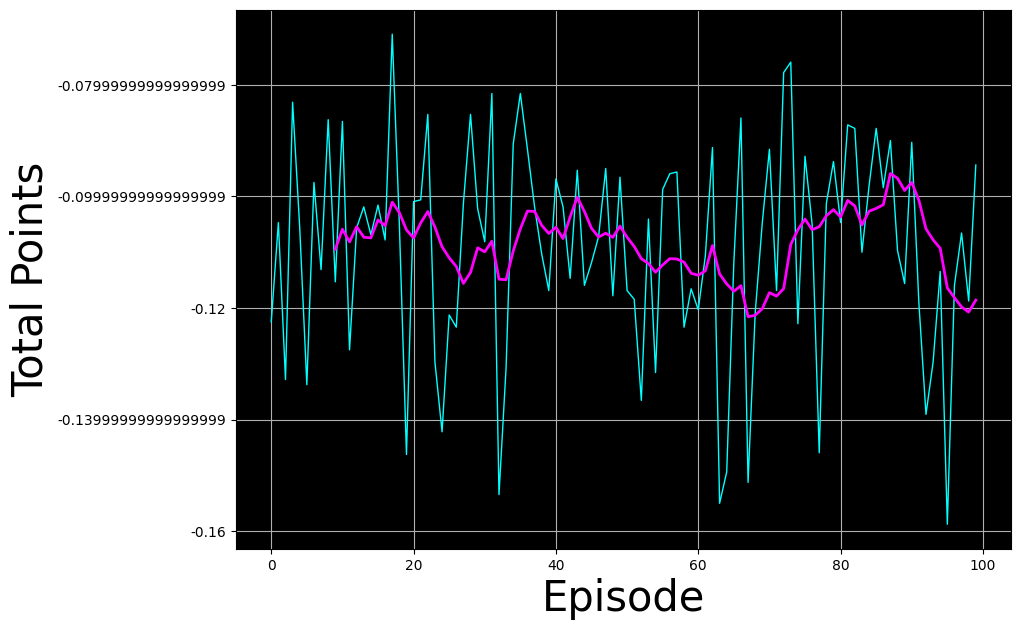

In [ ]:
plot_history(test_reward)